<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:14:10] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


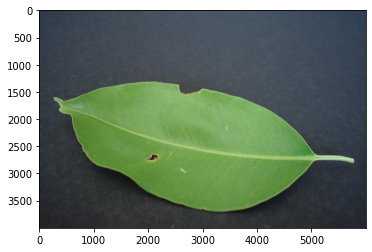

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

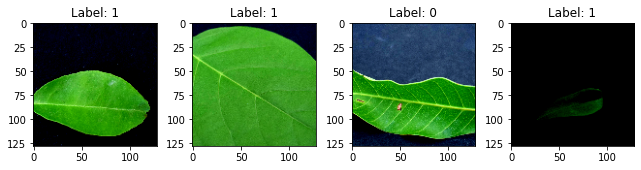

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:14:15] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:14:17] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.283617715609155 samples/sec                   batch loss = 0.9039356112480164 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2949183541218425 samples/sec                   batch loss = 0.7144786715507507 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.2989526056799352 samples/sec                   batch loss = 0.5680244565010071 | accuracy = 0.48333333333333334


Epoch[1] Batch[20] Speed: 1.2956791891131296 samples/sec                   batch loss = 1.0473577976226807 | accuracy = 0.4625


Epoch[1] Batch[25] Speed: 1.2953199612204247 samples/sec                   batch loss = 0.4849832057952881 | accuracy = 0.49


Epoch[1] Batch[30] Speed: 1.3010834441531642 samples/sec                   batch loss = 0.7919183373451233 | accuracy = 0.5083333333333333


Epoch[1] Batch[35] Speed: 1.2964221851089628 samples/sec                   batch loss = 1.545972228050232 | accuracy = 0.5071428571428571


Epoch[1] Batch[40] Speed: 1.3016964975062324 samples/sec                   batch loss = 0.6974033117294312 | accuracy = 0.5


Epoch[1] Batch[45] Speed: 1.2975734520987943 samples/sec                   batch loss = 0.5203433036804199 | accuracy = 0.5111111111111111


Epoch[1] Batch[50] Speed: 1.3009436120280486 samples/sec                   batch loss = 0.6128309369087219 | accuracy = 0.515


Epoch[1] Batch[55] Speed: 1.2975273902595361 samples/sec                   batch loss = 1.0477708578109741 | accuracy = 0.5136363636363637


Epoch[1] Batch[60] Speed: 1.2946983107016778 samples/sec                   batch loss = 0.9270435571670532 | accuracy = 0.525


Epoch[1] Batch[65] Speed: 1.2934821274789365 samples/sec                   batch loss = 0.5371429920196533 | accuracy = 0.5269230769230769


Epoch[1] Batch[70] Speed: 1.2967258962187442 samples/sec                   batch loss = 0.9951406717300415 | accuracy = 0.5321428571428571


Epoch[1] Batch[75] Speed: 1.2944391910742634 samples/sec                   batch loss = 0.4241706430912018 | accuracy = 0.5433333333333333


Epoch[1] Batch[80] Speed: 1.2981824982615164 samples/sec                   batch loss = 1.068934440612793 | accuracy = 0.55625


Epoch[1] Batch[85] Speed: 1.2961083027967288 samples/sec                   batch loss = 0.5163776278495789 | accuracy = 0.5676470588235294


Epoch[1] Batch[90] Speed: 1.3006416529913831 samples/sec                   batch loss = 0.3748365044593811 | accuracy = 0.5833333333333334


Epoch[1] Batch[95] Speed: 1.2968536958076615 samples/sec                   batch loss = 0.470658540725708 | accuracy = 0.5842105263157895


Epoch[1] Batch[100] Speed: 1.2954149756752815 samples/sec                   batch loss = 0.3757835924625397 | accuracy = 0.59


Epoch[1] Batch[105] Speed: 1.2975101304562084 samples/sec                   batch loss = 0.8664031028747559 | accuracy = 0.5952380952380952


Epoch[1] Batch[110] Speed: 1.2958661344340496 samples/sec                   batch loss = 0.5436229109764099 | accuracy = 0.5977272727272728


Epoch[1] Batch[115] Speed: 1.2955337133269529 samples/sec                   batch loss = 0.5332625508308411 | accuracy = 0.6043478260869565


Epoch[1] Batch[120] Speed: 1.2925296645490727 samples/sec                   batch loss = 0.7628772258758545 | accuracy = 0.6083333333333333


Epoch[1] Batch[125] Speed: 1.2916419439403664 samples/sec                   batch loss = 0.5629215240478516 | accuracy = 0.618


Epoch[1] Batch[130] Speed: 1.3001390015677876 samples/sec                   batch loss = 0.386646568775177 | accuracy = 0.625


Epoch[1] Batch[135] Speed: 1.2949054612322553 samples/sec                   batch loss = 0.4723300039768219 | accuracy = 0.6314814814814815


Epoch[1] Batch[140] Speed: 1.294032640332512 samples/sec                   batch loss = 0.6538281440734863 | accuracy = 0.6392857142857142


Epoch[1] Batch[145] Speed: 1.2981371967189903 samples/sec                   batch loss = 0.4813951849937439 | accuracy = 0.6396551724137931


Epoch[1] Batch[150] Speed: 1.2930264483201084 samples/sec                   batch loss = 0.4772685766220093 | accuracy = 0.6433333333333333


Epoch[1] Batch[155] Speed: 1.2979755030296278 samples/sec                   batch loss = 0.3934309780597687 | accuracy = 0.6451612903225806


Epoch[1] Batch[160] Speed: 1.296055736863516 samples/sec                   batch loss = 0.45669445395469666 | accuracy = 0.64375


Epoch[1] Batch[165] Speed: 1.297095932604762 samples/sec                   batch loss = 0.36046844720840454 | accuracy = 0.65


Epoch[1] Batch[170] Speed: 1.2978855344214895 samples/sec                   batch loss = 0.2703644931316376 | accuracy = 0.6529411764705882


Epoch[1] Batch[175] Speed: 1.2969719955215346 samples/sec                   batch loss = 0.5096114277839661 | accuracy = 0.6542857142857142


Epoch[1] Batch[180] Speed: 1.2982061045311353 samples/sec                   batch loss = 0.550983190536499 | accuracy = 0.6541666666666667


Epoch[1] Batch[185] Speed: 1.299004903976536 samples/sec                   batch loss = 0.8583390712738037 | accuracy = 0.6554054054054054


Epoch[1] Batch[190] Speed: 1.2976015524302935 samples/sec                   batch loss = 0.7743476629257202 | accuracy = 0.6539473684210526


Epoch[1] Batch[195] Speed: 1.2952263606090118 samples/sec                   batch loss = 1.003859043121338 | accuracy = 0.6576923076923077


Epoch[1] Batch[200] Speed: 1.2938051153728936 samples/sec                   batch loss = 0.7816206216812134 | accuracy = 0.655


Epoch[1] Batch[205] Speed: 1.2947603589720675 samples/sec                   batch loss = 1.0149760246276855 | accuracy = 0.6560975609756098


Epoch[1] Batch[210] Speed: 1.297118095372401 samples/sec                   batch loss = 1.1655564308166504 | accuracy = 0.6595238095238095


Epoch[1] Batch[215] Speed: 1.2928828627912687 samples/sec                   batch loss = 0.48953700065612793 | accuracy = 0.6593023255813953


Epoch[1] Batch[220] Speed: 1.298731591314704 samples/sec                   batch loss = 0.4190291166305542 | accuracy = 0.6602272727272728


Epoch[1] Batch[225] Speed: 1.2971006458901295 samples/sec                   batch loss = 0.7164548635482788 | accuracy = 0.6566666666666666


Epoch[1] Batch[230] Speed: 1.2999337993003057 samples/sec                   batch loss = 0.8693208694458008 | accuracy = 0.6554347826086957


Epoch[1] Batch[235] Speed: 1.295788667675768 samples/sec                   batch loss = 0.7570227384567261 | accuracy = 0.6574468085106383


Epoch[1] Batch[240] Speed: 1.2908651824588322 samples/sec                   batch loss = 0.6794507503509521 | accuracy = 0.65625


Epoch[1] Batch[245] Speed: 1.3022215798863883 samples/sec                   batch loss = 0.8924192190170288 | accuracy = 0.6551020408163265


Epoch[1] Batch[250] Speed: 1.2946015032987337 samples/sec                   batch loss = 1.2975564002990723 | accuracy = 0.655


Epoch[1] Batch[255] Speed: 1.2998582624968642 samples/sec                   batch loss = 0.5474778413772583 | accuracy = 0.6568627450980392


Epoch[1] Batch[260] Speed: 1.3026831573241615 samples/sec                   batch loss = 0.6228042244911194 | accuracy = 0.6548076923076923


Epoch[1] Batch[265] Speed: 1.301311517726835 samples/sec                   batch loss = 0.6336196660995483 | accuracy = 0.6547169811320754


Epoch[1] Batch[270] Speed: 1.2955446178756291 samples/sec                   batch loss = 0.8258076906204224 | accuracy = 0.6537037037037037


Epoch[1] Batch[275] Speed: 1.297584892801161 samples/sec                   batch loss = 0.3524824380874634 | accuracy = 0.6536363636363637


Epoch[1] Batch[280] Speed: 1.2993684935117218 samples/sec                   batch loss = 0.633901834487915 | accuracy = 0.65625


Epoch[1] Batch[285] Speed: 1.2995089937768907 samples/sec                   batch loss = 0.5352569222450256 | accuracy = 0.6570175438596492


Epoch[1] Batch[290] Speed: 1.2964289972590426 samples/sec                   batch loss = 0.39195626974105835 | accuracy = 0.6543103448275862


Epoch[1] Batch[295] Speed: 1.3027809748748291 samples/sec                   batch loss = 0.5065279006958008 | accuracy = 0.6559322033898305


Epoch[1] Batch[300] Speed: 1.3019179160517809 samples/sec                   batch loss = 0.504055917263031 | accuracy = 0.6541666666666667


Epoch[1] Batch[305] Speed: 1.30223199084157 samples/sec                   batch loss = 0.2621760070323944 | accuracy = 0.6557377049180327


Epoch[1] Batch[310] Speed: 1.2991766127989357 samples/sec                   batch loss = 0.5210388898849487 | accuracy = 0.6564516129032258


Epoch[1] Batch[315] Speed: 1.2986750928904163 samples/sec                   batch loss = 0.3388117551803589 | accuracy = 0.6563492063492063


Epoch[1] Batch[320] Speed: 1.3011235026162893 samples/sec                   batch loss = 0.4802010953426361 | accuracy = 0.6578125


Epoch[1] Batch[325] Speed: 1.3023341887626703 samples/sec                   batch loss = 0.6006122827529907 | accuracy = 0.6584615384615384


Epoch[1] Batch[330] Speed: 1.305459812866531 samples/sec                   batch loss = 0.4530055522918701 | accuracy = 0.6598484848484848


Epoch[1] Batch[335] Speed: 1.3004473800744758 samples/sec                   batch loss = 0.6957056522369385 | accuracy = 0.6611940298507463


Epoch[1] Batch[340] Speed: 1.2970571245146438 samples/sec                   batch loss = 0.4893780052661896 | accuracy = 0.6647058823529411


Epoch[1] Batch[345] Speed: 1.2958458160290287 samples/sec                   batch loss = 0.3325464427471161 | accuracy = 0.6652173913043479


Epoch[1] Batch[350] Speed: 1.3013368529554827 samples/sec                   batch loss = 0.22629380226135254 | accuracy = 0.6685714285714286


Epoch[1] Batch[355] Speed: 1.3016996283566225 samples/sec                   batch loss = 0.525393009185791 | accuracy = 0.671830985915493


Epoch[1] Batch[360] Speed: 1.2990114415597165 samples/sec                   batch loss = 1.0309274196624756 | accuracy = 0.6729166666666667


Epoch[1] Batch[365] Speed: 1.2999564620532973 samples/sec                   batch loss = 1.0030268430709839 | accuracy = 0.6726027397260274


Epoch[1] Batch[370] Speed: 1.2997225197481375 samples/sec                   batch loss = 0.46926116943359375 | accuracy = 0.6743243243243243


Epoch[1] Batch[375] Speed: 1.2972918135190032 samples/sec                   batch loss = 0.4670652747154236 | accuracy = 0.674


Epoch[1] Batch[380] Speed: 1.2951096787919238 samples/sec                   batch loss = 0.4098975658416748 | accuracy = 0.6763157894736842


Epoch[1] Batch[385] Speed: 1.2983505735126892 samples/sec                   batch loss = 0.8226582407951355 | accuracy = 0.6766233766233766


Epoch[1] Batch[390] Speed: 1.2969610669313587 samples/sec                   batch loss = 0.6052793264389038 | accuracy = 0.6788461538461539


Epoch[1] Batch[395] Speed: 1.2935890407579007 samples/sec                   batch loss = 0.23665021359920502 | accuracy = 0.6797468354430379


Epoch[1] Batch[400] Speed: 1.3050179889789355 samples/sec                   batch loss = 0.4448988735675812 | accuracy = 0.68125


Epoch[1] Batch[405] Speed: 1.3042048852521257 samples/sec                   batch loss = 0.30434495210647583 | accuracy = 0.6814814814814815


Epoch[1] Batch[410] Speed: 1.2992709864760463 samples/sec                   batch loss = 0.26984941959381104 | accuracy = 0.6829268292682927


Epoch[1] Batch[415] Speed: 1.3080868620244592 samples/sec                   batch loss = 0.17438000440597534 | accuracy = 0.6849397590361446


Epoch[1] Batch[420] Speed: 1.30716094795335 samples/sec                   batch loss = 0.335712194442749 | accuracy = 0.6851190476190476


Epoch[1] Batch[425] Speed: 1.3043118547181516 samples/sec                   batch loss = 0.5027773380279541 | accuracy = 0.6858823529411765


Epoch[1] Batch[430] Speed: 1.2988604904608105 samples/sec                   batch loss = 0.21179397404193878 | accuracy = 0.6883720930232559


Epoch[1] Batch[435] Speed: 1.3039084028769397 samples/sec                   batch loss = 0.5125090479850769 | accuracy = 0.6890804597701149


Epoch[1] Batch[440] Speed: 1.3019567124561204 samples/sec                   batch loss = 0.8139562606811523 | accuracy = 0.6880681818181819


Epoch[1] Batch[445] Speed: 1.2981426206838493 samples/sec                   batch loss = 1.0362275838851929 | accuracy = 0.6870786516853933


Epoch[1] Batch[450] Speed: 1.296618864653498 samples/sec                   batch loss = 0.5726920962333679 | accuracy = 0.6872222222222222


Epoch[1] Batch[455] Speed: 1.3033837821897156 samples/sec                   batch loss = 0.20730192959308624 | accuracy = 0.6901098901098901


Epoch[1] Batch[460] Speed: 1.3001001119217033 samples/sec                   batch loss = 0.6175889372825623 | accuracy = 0.6918478260869565


Epoch[1] Batch[465] Speed: 1.3058694092918142 samples/sec                   batch loss = 0.3916947543621063 | accuracy = 0.693010752688172


Epoch[1] Batch[470] Speed: 1.3013718797767226 samples/sec                   batch loss = 0.33677777647972107 | accuracy = 0.6920212765957446


Epoch[1] Batch[475] Speed: 1.3024077892873078 samples/sec                   batch loss = 0.23255100846290588 | accuracy = 0.6926315789473684


Epoch[1] Batch[480] Speed: 1.2998144551730935 samples/sec                   batch loss = 0.4832881689071655 | accuracy = 0.69375


Epoch[1] Batch[485] Speed: 1.3009532964012205 samples/sec                   batch loss = 1.0282875299453735 | accuracy = 0.6922680412371134


Epoch[1] Batch[490] Speed: 1.2980574495793533 samples/sec                   batch loss = 0.26321643590927124 | accuracy = 0.6928571428571428


Epoch[1] Batch[495] Speed: 1.3053553972409015 samples/sec                   batch loss = 0.7912745475769043 | accuracy = 0.6924242424242424


Epoch[1] Batch[500] Speed: 1.3018105307721328 samples/sec                   batch loss = 0.791438102722168 | accuracy = 0.6915


Epoch[1] Batch[505] Speed: 1.3053039065795045 samples/sec                   batch loss = 0.8975304365158081 | accuracy = 0.6896039603960396


Epoch[1] Batch[510] Speed: 1.3009277743534662 samples/sec                   batch loss = 0.5228443145751953 | accuracy = 0.6892156862745098


Epoch[1] Batch[515] Speed: 1.2997654146149484 samples/sec                   batch loss = 0.46802476048469543 | accuracy = 0.6893203883495146


Epoch[1] Batch[520] Speed: 1.3012754848579076 samples/sec                   batch loss = 0.39685946702957153 | accuracy = 0.6899038461538461


Epoch[1] Batch[525] Speed: 1.3023236750810634 samples/sec                   batch loss = 0.574263870716095 | accuracy = 0.69


Epoch[1] Batch[530] Speed: 1.301749522004847 samples/sec                   batch loss = 0.13573378324508667 | accuracy = 0.6915094339622642


Epoch[1] Batch[535] Speed: 1.2971291268965157 samples/sec                   batch loss = 1.4201387166976929 | accuracy = 0.6920560747663551


Epoch[1] Batch[540] Speed: 1.2968153031665786 samples/sec                   batch loss = 0.4410898685455322 | accuracy = 0.6921296296296297


Epoch[1] Batch[545] Speed: 1.3014734379339288 samples/sec                   batch loss = 0.17972321808338165 | accuracy = 0.6926605504587156


Epoch[1] Batch[550] Speed: 1.304525237693537 samples/sec                   batch loss = 0.5304790735244751 | accuracy = 0.6927272727272727


Epoch[1] Batch[555] Speed: 1.299179731539352 samples/sec                   batch loss = 0.2628132998943329 | accuracy = 0.6932432432432433


Epoch[1] Batch[560] Speed: 1.2956608777775127 samples/sec                   batch loss = 0.31733429431915283 | accuracy = 0.6915178571428572


Epoch[1] Batch[565] Speed: 1.3001403113632055 samples/sec                   batch loss = 1.4426928758621216 | accuracy = 0.6907079646017699


Epoch[1] Batch[570] Speed: 1.2942054331243362 samples/sec                   batch loss = 0.6827508807182312 | accuracy = 0.6907894736842105


Epoch[1] Batch[575] Speed: 1.2991633331686525 samples/sec                   batch loss = 0.43961846828460693 | accuracy = 0.691304347826087


Epoch[1] Batch[580] Speed: 1.3034089956515007 samples/sec                   batch loss = 0.7552598714828491 | accuracy = 0.6918103448275862


Epoch[1] Batch[585] Speed: 1.301617423279109 samples/sec                   batch loss = 0.6420543789863586 | accuracy = 0.6918803418803419


Epoch[1] Batch[590] Speed: 1.3071368112162534 samples/sec                   batch loss = 0.5763553977012634 | accuracy = 0.6902542372881356


Epoch[1] Batch[595] Speed: 1.297666288182316 samples/sec                   batch loss = 0.7109742760658264 | accuracy = 0.6907563025210084


Epoch[1] Batch[600] Speed: 1.3008013894057808 samples/sec                   batch loss = 0.6933116912841797 | accuracy = 0.6920833333333334


Epoch[1] Batch[605] Speed: 1.3003313682515516 samples/sec                   batch loss = 0.6920174360275269 | accuracy = 0.6917355371900826


Epoch[1] Batch[610] Speed: 1.302239672818144 samples/sec                   batch loss = 0.4001004099845886 | accuracy = 0.6913934426229508


Epoch[1] Batch[615] Speed: 1.2932469206481398 samples/sec                   batch loss = 0.6210012435913086 | accuracy = 0.6922764227642276


Epoch[1] Batch[620] Speed: 1.2979107364235387 samples/sec                   batch loss = 0.2131008803844452 | accuracy = 0.6935483870967742


Epoch[1] Batch[625] Speed: 1.3021400163190342 samples/sec                   batch loss = 0.36897194385528564 | accuracy = 0.6936


Epoch[1] Batch[630] Speed: 1.2961029959471133 samples/sec                   batch loss = 0.39473167061805725 | accuracy = 0.6932539682539682


Epoch[1] Batch[635] Speed: 1.2990164705146336 samples/sec                   batch loss = 0.5275206565856934 | accuracy = 0.6937007874015748


Epoch[1] Batch[640] Speed: 1.3011436841366049 samples/sec                   batch loss = 0.31973996758461 | accuracy = 0.69375


Epoch[1] Batch[645] Speed: 1.300760241426428 samples/sec                   batch loss = 0.24014069139957428 | accuracy = 0.6949612403100776


Epoch[1] Batch[650] Speed: 1.3034829202582816 samples/sec                   batch loss = 0.6266603469848633 | accuracy = 0.695


Epoch[1] Batch[655] Speed: 1.299550465278313 samples/sec                   batch loss = 0.3914359509944916 | accuracy = 0.6950381679389313


Epoch[1] Batch[660] Speed: 1.3007876731234072 samples/sec                   batch loss = 0.691899299621582 | accuracy = 0.6943181818181818


Epoch[1] Batch[665] Speed: 1.2971697445798418 samples/sec                   batch loss = 0.11730460822582245 | accuracy = 0.6954887218045113


Epoch[1] Batch[670] Speed: 1.299727654899907 samples/sec                   batch loss = 0.7392277121543884 | accuracy = 0.6955223880597015


Epoch[1] Batch[675] Speed: 1.3022031842365975 samples/sec                   batch loss = 0.7146697044372559 | accuracy = 0.6962962962962963


Epoch[1] Batch[680] Speed: 1.3015545141219214 samples/sec                   batch loss = 0.3784426152706146 | accuracy = 0.6963235294117647


Epoch[1] Batch[685] Speed: 1.295895161832258 samples/sec                   batch loss = 0.5472809672355652 | accuracy = 0.6963503649635037


Epoch[1] Batch[690] Speed: 1.2975440484121474 samples/sec                   batch loss = 0.47117888927459717 | accuracy = 0.6971014492753623


Epoch[1] Batch[695] Speed: 1.2963066899906663 samples/sec                   batch loss = 0.756406307220459 | accuracy = 0.6971223021582734


Epoch[1] Batch[700] Speed: 1.3027638785041757 samples/sec                   batch loss = 0.2724738121032715 | accuracy = 0.6975


Epoch[1] Batch[705] Speed: 1.3038872234841856 samples/sec                   batch loss = 0.1816677451133728 | accuracy = 0.6978723404255319


Epoch[1] Batch[710] Speed: 1.302416989937819 samples/sec                   batch loss = 0.4760785400867462 | accuracy = 0.6985915492957746


Epoch[1] Batch[715] Speed: 1.3010397559967297 samples/sec                   batch loss = 1.2848870754241943 | accuracy = 0.6982517482517483


Epoch[1] Batch[720] Speed: 1.306662201366849 samples/sec                   batch loss = 0.7239100337028503 | accuracy = 0.6982638888888889


Epoch[1] Batch[725] Speed: 1.298277129421404 samples/sec                   batch loss = 0.684573233127594 | accuracy = 0.6979310344827586


Epoch[1] Batch[730] Speed: 1.3009097178573517 samples/sec                   batch loss = 0.7212334275245667 | accuracy = 0.697945205479452


Epoch[1] Batch[735] Speed: 1.2987213367871533 samples/sec                   batch loss = 0.6063264012336731 | accuracy = 0.6982993197278912


Epoch[1] Batch[740] Speed: 1.306486066521455 samples/sec                   batch loss = 0.5242617130279541 | accuracy = 0.6989864864864865


Epoch[1] Batch[745] Speed: 1.2974109958284177 samples/sec                   batch loss = 0.4916665554046631 | accuracy = 0.6989932885906041


Epoch[1] Batch[750] Speed: 1.2985028131027518 samples/sec                   batch loss = 1.1672924757003784 | accuracy = 0.7003333333333334


Epoch[1] Batch[755] Speed: 1.2949640309981545 samples/sec                   batch loss = 0.8604981899261475 | accuracy = 0.7006622516556291


Epoch[1] Batch[760] Speed: 1.2982988302305574 samples/sec                   batch loss = 0.43897169828414917 | accuracy = 0.7006578947368421


Epoch[1] Batch[765] Speed: 1.3026857871798951 samples/sec                   batch loss = 0.4390224814414978 | accuracy = 0.7019607843137254


Epoch[1] Batch[770] Speed: 1.296228369366169 samples/sec                   batch loss = 0.7357790470123291 | accuracy = 0.7016233766233766


Epoch[1] Batch[775] Speed: 1.299754036123199 samples/sec                   batch loss = 0.7427724599838257 | accuracy = 0.702258064516129


Epoch[1] Batch[780] Speed: 1.289961992090252 samples/sec                   batch loss = 0.8387405872344971 | accuracy = 0.7022435897435897


Epoch[1] Batch[785] Speed: 1.2950430985905925 samples/sec                   batch loss = 0.5972698926925659 | accuracy = 0.7022292993630573


[Epoch 1] training: accuracy=0.7024111675126904
[Epoch 1] time cost: 633.9992129802704
[Epoch 1] validation: validation accuracy=0.7644444444444445


Epoch[2] Batch[5] Speed: 1.3027404096610427 samples/sec                   batch loss = 0.08894851058721542 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.3057849490083415 samples/sec                   batch loss = 0.35707637667655945 | accuracy = 0.8


Epoch[2] Batch[15] Speed: 1.3030864584442559 samples/sec                   batch loss = 0.29169172048568726 | accuracy = 0.8166666666666667


Epoch[2] Batch[20] Speed: 1.3003566653291492 samples/sec                   batch loss = 1.002847671508789 | accuracy = 0.75


Epoch[2] Batch[25] Speed: 1.3043652953268297 samples/sec                   batch loss = 0.6411871314048767 | accuracy = 0.72


Epoch[2] Batch[30] Speed: 1.3054649934540843 samples/sec                   batch loss = 0.659719705581665 | accuracy = 0.7166666666666667


Epoch[2] Batch[35] Speed: 1.3053521472171157 samples/sec                   batch loss = 0.6791282892227173 | accuracy = 0.7142857142857143


Epoch[2] Batch[40] Speed: 1.2986479512673865 samples/sec                   batch loss = 0.4499667286872864 | accuracy = 0.7125


Epoch[2] Batch[45] Speed: 1.3031656100444602 samples/sec                   batch loss = 0.21004623174667358 | accuracy = 0.7166666666666667


Epoch[2] Batch[50] Speed: 1.2946767300885726 samples/sec                   batch loss = 0.4339161217212677 | accuracy = 0.715


Epoch[2] Batch[55] Speed: 1.2921138632089775 samples/sec                   batch loss = 0.44483712315559387 | accuracy = 0.7136363636363636


Epoch[2] Batch[60] Speed: 1.30037561358577 samples/sec                   batch loss = 0.29791924357414246 | accuracy = 0.725


Epoch[2] Batch[65] Speed: 1.298272005725107 samples/sec                   batch loss = 0.2622409462928772 | accuracy = 0.7384615384615385


Epoch[2] Batch[70] Speed: 1.3012091774822745 samples/sec                   batch loss = 1.1663634777069092 | accuracy = 0.7392857142857143


Epoch[2] Batch[75] Speed: 1.300450000910776 samples/sec                   batch loss = 0.2513013482093811 | accuracy = 0.75


Epoch[2] Batch[80] Speed: 1.2997769947004767 samples/sec                   batch loss = 0.5020102858543396 | accuracy = 0.734375


Epoch[2] Batch[85] Speed: 1.3024581416909022 samples/sec                   batch loss = 0.6335194110870361 | accuracy = 0.7352941176470589


Epoch[2] Batch[90] Speed: 1.3032079226440278 samples/sec                   batch loss = 0.8460328578948975 | accuracy = 0.7361111111111112


Epoch[2] Batch[95] Speed: 1.3068580303238257 samples/sec                   batch loss = 0.5365179181098938 | accuracy = 0.7315789473684211


Epoch[2] Batch[100] Speed: 1.302479274682798 samples/sec                   batch loss = 0.33036932349205017 | accuracy = 0.735


Epoch[2] Batch[105] Speed: 1.298509345633088 samples/sec                   batch loss = 0.5502911806106567 | accuracy = 0.7428571428571429


Epoch[2] Batch[110] Speed: 1.30481499856081 samples/sec                   batch loss = 0.3764118254184723 | accuracy = 0.7363636363636363


Epoch[2] Batch[115] Speed: 1.3029636001996552 samples/sec                   batch loss = 0.45041972398757935 | accuracy = 0.7369565217391304


Epoch[2] Batch[120] Speed: 1.3004173420127987 samples/sec                   batch loss = 0.7874730825424194 | accuracy = 0.7395833333333334


Epoch[2] Batch[125] Speed: 1.3011369232575638 samples/sec                   batch loss = 0.46870097517967224 | accuracy = 0.74


Epoch[2] Batch[130] Speed: 1.298490552223268 samples/sec                   batch loss = 0.305661678314209 | accuracy = 0.7403846153846154


Epoch[2] Batch[135] Speed: 1.2998978426870356 samples/sec                   batch loss = 0.4852212071418762 | accuracy = 0.7444444444444445


Epoch[2] Batch[140] Speed: 1.3063125219620333 samples/sec                   batch loss = 0.2744041383266449 | accuracy = 0.7428571428571429


Epoch[2] Batch[145] Speed: 1.3038975597525884 samples/sec                   batch loss = 0.6086578369140625 | accuracy = 0.7413793103448276


Epoch[2] Batch[150] Speed: 1.2993312599958815 samples/sec                   batch loss = 0.5508531928062439 | accuracy = 0.74


Epoch[2] Batch[155] Speed: 1.3041543977040586 samples/sec                   batch loss = 0.2712208926677704 | accuracy = 0.7419354838709677


Epoch[2] Batch[160] Speed: 1.2946546506688295 samples/sec                   batch loss = 0.6941462755203247 | accuracy = 0.74375


Epoch[2] Batch[165] Speed: 1.3024934311374758 samples/sec                   batch loss = 0.7223940491676331 | accuracy = 0.7424242424242424


Epoch[2] Batch[170] Speed: 1.3016341866167318 samples/sec                   batch loss = 0.19675473868846893 | accuracy = 0.7441176470588236


Epoch[2] Batch[175] Speed: 1.2986413168209776 samples/sec                   batch loss = 2.2403862476348877 | accuracy = 0.7428571428571429


Epoch[2] Batch[180] Speed: 1.2992360726543717 samples/sec                   batch loss = 0.35817620158195496 | accuracy = 0.7430555555555556


Epoch[2] Batch[185] Speed: 1.2999462888975464 samples/sec                   batch loss = 0.3834637701511383 | accuracy = 0.7405405405405405


Epoch[2] Batch[190] Speed: 1.2962619198815832 samples/sec                   batch loss = 0.3047347962856293 | accuracy = 0.7447368421052631


Epoch[2] Batch[195] Speed: 1.3038236894339261 samples/sec                   batch loss = 0.3198257088661194 | accuracy = 0.7448717948717949


Epoch[2] Batch[200] Speed: 1.3049051185113463 samples/sec                   batch loss = 0.3687259554862976 | accuracy = 0.7475


Epoch[2] Batch[205] Speed: 1.3089678238520406 samples/sec                   batch loss = 0.3787371516227722 | accuracy = 0.748780487804878


Epoch[2] Batch[210] Speed: 1.302393028075652 samples/sec                   batch loss = 0.32868802547454834 | accuracy = 0.7511904761904762


Epoch[2] Batch[215] Speed: 1.2994152900105473 samples/sec                   batch loss = 0.22016367316246033 | accuracy = 0.7523255813953489


Epoch[2] Batch[220] Speed: 1.3014660678722456 samples/sec                   batch loss = 0.867827296257019 | accuracy = 0.7511363636363636


Epoch[2] Batch[225] Speed: 1.3012778062431056 samples/sec                   batch loss = 0.1605878323316574 | accuracy = 0.7533333333333333


Epoch[2] Batch[230] Speed: 1.2969709928909094 samples/sec                   batch loss = 1.0131217241287231 | accuracy = 0.7521739130434782


Epoch[2] Batch[235] Speed: 1.300643770452393 samples/sec                   batch loss = 1.7275446653366089 | accuracy = 0.7489361702127659


Epoch[2] Batch[240] Speed: 1.2919949556089894 samples/sec                   batch loss = 0.41270172595977783 | accuracy = 0.7489583333333333


Epoch[2] Batch[245] Speed: 1.297054417060132 samples/sec                   batch loss = 0.8652359247207642 | accuracy = 0.7489795918367347


Epoch[2] Batch[250] Speed: 1.2943280431689144 samples/sec                   batch loss = 0.20330041646957397 | accuracy = 0.749


Epoch[2] Batch[255] Speed: 1.2978392496285112 samples/sec                   batch loss = 0.40650802850723267 | accuracy = 0.7480392156862745


Epoch[2] Batch[260] Speed: 1.2966984351245632 samples/sec                   batch loss = 0.7401816844940186 | accuracy = 0.7490384615384615


Epoch[2] Batch[265] Speed: 1.295362966036479 samples/sec                   batch loss = 0.438831090927124 | accuracy = 0.7471698113207547


Epoch[2] Batch[270] Speed: 1.290786425567044 samples/sec                   batch loss = 0.8477426171302795 | accuracy = 0.7453703703703703


Epoch[2] Batch[275] Speed: 1.3027373749585838 samples/sec                   batch loss = 0.5182911157608032 | accuracy = 0.7418181818181818


Epoch[2] Batch[280] Speed: 1.2903201394023103 samples/sec                   batch loss = 0.5289667248725891 | accuracy = 0.7419642857142857


Epoch[2] Batch[285] Speed: 1.294712298520372 samples/sec                   batch loss = 0.7513808608055115 | accuracy = 0.7429824561403509


Epoch[2] Batch[290] Speed: 1.2923961449390866 samples/sec                   batch loss = 0.42086678743362427 | accuracy = 0.7439655172413793


Epoch[2] Batch[295] Speed: 1.29029136121948 samples/sec                   batch loss = 0.6631267070770264 | accuracy = 0.7449152542372881


Epoch[2] Batch[300] Speed: 1.2961418470969408 samples/sec                   batch loss = 0.6913344860076904 | accuracy = 0.7458333333333333


Epoch[2] Batch[305] Speed: 1.2951289743338956 samples/sec                   batch loss = 0.9381548166275024 | accuracy = 0.7442622950819672


Epoch[2] Batch[310] Speed: 1.2952028625799503 samples/sec                   batch loss = 0.5311648845672607 | accuracy = 0.742741935483871


Epoch[2] Batch[315] Speed: 1.2977403658502438 samples/sec                   batch loss = 0.4123013913631439 | accuracy = 0.7388888888888889


Epoch[2] Batch[320] Speed: 1.300575107729985 samples/sec                   batch loss = 0.24603578448295593 | accuracy = 0.74140625


Epoch[2] Batch[325] Speed: 1.305236578766672 samples/sec                   batch loss = 0.46251386404037476 | accuracy = 0.7407692307692307


Epoch[2] Batch[330] Speed: 1.3002051999168598 samples/sec                   batch loss = 0.4611666798591614 | accuracy = 0.7386363636363636


Epoch[2] Batch[335] Speed: 1.2975157498766459 samples/sec                   batch loss = 0.607447624206543 | accuracy = 0.7395522388059701


Epoch[2] Batch[340] Speed: 1.2989419453900155 samples/sec                   batch loss = 0.293091744184494 | accuracy = 0.7419117647058824


Epoch[2] Batch[345] Speed: 1.3000467180112774 samples/sec                   batch loss = 0.37614089250564575 | accuracy = 0.7405797101449275


Epoch[2] Batch[350] Speed: 1.3020792798291214 samples/sec                   batch loss = 0.18818864226341248 | accuracy = 0.7407142857142858


Epoch[2] Batch[355] Speed: 1.302154266465904 samples/sec                   batch loss = 0.3072466552257538 | accuracy = 0.7422535211267606


Epoch[2] Batch[360] Speed: 1.294678128810211 samples/sec                   batch loss = 0.434354305267334 | accuracy = 0.7423611111111111


Epoch[2] Batch[365] Speed: 1.2976480210058952 samples/sec                   batch loss = 0.47736820578575134 | accuracy = 0.7431506849315068


Epoch[2] Batch[370] Speed: 1.299352996059395 samples/sec                   batch loss = 0.4318455457687378 | accuracy = 0.7432432432432432


Epoch[2] Batch[375] Speed: 1.2954737916061452 samples/sec                   batch loss = 0.2517548203468323 | accuracy = 0.7446666666666667


Epoch[2] Batch[380] Speed: 1.300490121185019 samples/sec                   batch loss = 0.7010080814361572 | accuracy = 0.743421052631579


Epoch[2] Batch[385] Speed: 1.2964079599675735 samples/sec                   batch loss = 0.6287608742713928 | accuracy = 0.7448051948051948


Epoch[2] Batch[390] Speed: 1.2981305674901595 samples/sec                   batch loss = 0.3248051106929779 | accuracy = 0.7455128205128205


Epoch[2] Batch[395] Speed: 1.2962958727682317 samples/sec                   batch loss = 0.37984606623649597 | accuracy = 0.7462025316455696


Epoch[2] Batch[400] Speed: 1.2924082909963432 samples/sec                   batch loss = 0.5189934372901917 | accuracy = 0.7475


Epoch[2] Batch[405] Speed: 1.298234332729531 samples/sec                   batch loss = 0.2506062388420105 | accuracy = 0.7487654320987654


Epoch[2] Batch[410] Speed: 1.300581157017823 samples/sec                   batch loss = 0.3724561333656311 | accuracy = 0.749390243902439


Epoch[2] Batch[415] Speed: 1.302902786857416 samples/sec                   batch loss = 0.5298935174942017 | accuracy = 0.7463855421686747


Epoch[2] Batch[420] Speed: 1.3006536520282672 samples/sec                   batch loss = 0.43805113434791565 | accuracy = 0.7452380952380953


Epoch[2] Batch[425] Speed: 1.2944343972397276 samples/sec                   batch loss = 0.20608967542648315 | accuracy = 0.7464705882352941


Epoch[2] Batch[430] Speed: 1.3008598885634046 samples/sec                   batch loss = 0.3909214437007904 | accuracy = 0.7447674418604651


Epoch[2] Batch[435] Speed: 1.2924455270536095 samples/sec                   batch loss = 0.4302290678024292 | accuracy = 0.7459770114942529


Epoch[2] Batch[440] Speed: 1.2892690806024483 samples/sec                   batch loss = 0.2810165286064148 | accuracy = 0.7460227272727272


Epoch[2] Batch[445] Speed: 1.2990983473780031 samples/sec                   batch loss = 0.6635124087333679 | accuracy = 0.7455056179775281


Epoch[2] Batch[450] Speed: 1.2967257959936582 samples/sec                   batch loss = 0.5173967480659485 | accuracy = 0.7466666666666667


Epoch[2] Batch[455] Speed: 1.3021351652763666 samples/sec                   batch loss = 0.13642188906669617 | accuracy = 0.7461538461538462


Epoch[2] Batch[460] Speed: 1.2981446295712256 samples/sec                   batch loss = 0.20899038016796112 | accuracy = 0.7456521739130435


Epoch[2] Batch[465] Speed: 1.2967808218966317 samples/sec                   batch loss = 0.4004529118537903 | accuracy = 0.7451612903225806


Epoch[2] Batch[470] Speed: 1.2987883962875428 samples/sec                   batch loss = 0.5466358065605164 | accuracy = 0.7462765957446809


Epoch[2] Batch[475] Speed: 1.306302452503199 samples/sec                   batch loss = 0.5020129680633545 | accuracy = 0.7463157894736843


Epoch[2] Batch[480] Speed: 1.2991503556104382 samples/sec                   batch loss = 0.19449777901172638 | accuracy = 0.7453125


Epoch[2] Batch[485] Speed: 1.2941008136061414 samples/sec                   batch loss = 0.4005020260810852 | accuracy = 0.7438144329896907


Epoch[2] Batch[490] Speed: 1.2973234127556403 samples/sec                   batch loss = 0.3345201909542084 | accuracy = 0.7428571428571429


Epoch[2] Batch[495] Speed: 1.2982340313543819 samples/sec                   batch loss = 0.4994640052318573 | accuracy = 0.7414141414141414


Epoch[2] Batch[500] Speed: 1.2916501975752057 samples/sec                   batch loss = 0.4149114489555359 | accuracy = 0.741


Epoch[2] Batch[505] Speed: 1.2933798184465641 samples/sec                   batch loss = 0.8610817790031433 | accuracy = 0.7400990099009901


Epoch[2] Batch[510] Speed: 1.2949330463322577 samples/sec                   batch loss = 0.9069593548774719 | accuracy = 0.7397058823529412


Epoch[2] Batch[515] Speed: 1.2933306640150273 samples/sec                   batch loss = 0.2441920042037964 | accuracy = 0.7407766990291262


Epoch[2] Batch[520] Speed: 1.291659346305757 samples/sec                   batch loss = 0.1773976981639862 | accuracy = 0.7418269230769231


Epoch[2] Batch[525] Speed: 1.2932667588702527 samples/sec                   batch loss = 0.32452356815338135 | accuracy = 0.7428571428571429


Epoch[2] Batch[530] Speed: 1.2882245795644465 samples/sec                   batch loss = 0.34818175435066223 | accuracy = 0.7438679245283019


Epoch[2] Batch[535] Speed: 1.294373578546989 samples/sec                   batch loss = 0.5270394086837769 | accuracy = 0.7434579439252337


Epoch[2] Batch[540] Speed: 1.2851029781114016 samples/sec                   batch loss = 1.0602322816848755 | accuracy = 0.7435185185185185


Epoch[2] Batch[545] Speed: 1.2985106521470426 samples/sec                   batch loss = 0.1482473611831665 | accuracy = 0.744954128440367


Epoch[2] Batch[550] Speed: 1.303872226052799 samples/sec                   batch loss = 0.9082356095314026 | accuracy = 0.7445454545454545


Epoch[2] Batch[555] Speed: 1.3004842743577987 samples/sec                   batch loss = 0.30638888478279114 | accuracy = 0.7441441441441441


Epoch[2] Batch[560] Speed: 1.2970201236146235 samples/sec                   batch loss = 0.12374217808246613 | accuracy = 0.7441964285714285


Epoch[2] Batch[565] Speed: 1.3013142429829645 samples/sec                   batch loss = 1.0116020441055298 | accuracy = 0.7438053097345133


Epoch[2] Batch[570] Speed: 1.306708710518562 samples/sec                   batch loss = 0.4570223093032837 | accuracy = 0.7447368421052631


Epoch[2] Batch[575] Speed: 1.3005624044086925 samples/sec                   batch loss = 0.9918025732040405 | accuracy = 0.7456521739130435


Epoch[2] Batch[580] Speed: 1.299394457604481 samples/sec                   batch loss = 0.8080471754074097 | accuracy = 0.7456896551724138


Epoch[2] Batch[585] Speed: 1.2989290728203076 samples/sec                   batch loss = 0.5715712904930115 | accuracy = 0.7448717948717949


Epoch[2] Batch[590] Speed: 1.2961693847604985 samples/sec                   batch loss = 0.45448482036590576 | accuracy = 0.7444915254237288


Epoch[2] Batch[595] Speed: 1.297394441420383 samples/sec                   batch loss = 0.8429036736488342 | accuracy = 0.7449579831932773


Epoch[2] Batch[600] Speed: 1.297900896481571 samples/sec                   batch loss = 0.24191740155220032 | accuracy = 0.7454166666666666


Epoch[2] Batch[605] Speed: 1.3019960163796238 samples/sec                   batch loss = 0.8259510397911072 | accuracy = 0.7458677685950413


Epoch[2] Batch[610] Speed: 1.2962333767955194 samples/sec                   batch loss = 0.22981961071491241 | accuracy = 0.7459016393442623


Epoch[2] Batch[615] Speed: 1.2989553210647626 samples/sec                   batch loss = 1.0066452026367188 | accuracy = 0.7455284552845528


Epoch[2] Batch[620] Speed: 1.2970516093414655 samples/sec                   batch loss = 0.2473503053188324 | accuracy = 0.7455645161290323


Epoch[2] Batch[625] Speed: 1.3022529143326236 samples/sec                   batch loss = 0.5239756107330322 | accuracy = 0.7452


Epoch[2] Batch[630] Speed: 1.2963064896700918 samples/sec                   batch loss = 0.23121686279773712 | accuracy = 0.7464285714285714


Epoch[2] Batch[635] Speed: 1.2935559276666593 samples/sec                   batch loss = 0.4341907501220703 | accuracy = 0.747244094488189


Epoch[2] Batch[640] Speed: 1.292000228871386 samples/sec                   batch loss = 0.45811429619789124 | accuracy = 0.74609375


Epoch[2] Batch[645] Speed: 1.2910185525834543 samples/sec                   batch loss = 0.44130268692970276 | accuracy = 0.7445736434108527


Epoch[2] Batch[650] Speed: 1.2949053612883776 samples/sec                   batch loss = 0.8023049831390381 | accuracy = 0.7434615384615385


Epoch[2] Batch[655] Speed: 1.2944449836717014 samples/sec                   batch loss = 0.4332752823829651 | accuracy = 0.7450381679389313


Epoch[2] Batch[660] Speed: 1.289524548420497 samples/sec                   batch loss = 0.5004206895828247 | accuracy = 0.7446969696969697


Epoch[2] Batch[665] Speed: 1.2972573069046882 samples/sec                   batch loss = 0.17013347148895264 | accuracy = 0.7458646616541353


Epoch[2] Batch[670] Speed: 1.2898927665986888 samples/sec                   batch loss = 0.2322090119123459 | accuracy = 0.7473880597014926


Epoch[2] Batch[675] Speed: 1.2906159344282926 samples/sec                   batch loss = 0.30718135833740234 | accuracy = 0.7485185185185185


Epoch[2] Batch[680] Speed: 1.297185290292212 samples/sec                   batch loss = 0.28795191645622253 | accuracy = 0.7496323529411765


Epoch[2] Batch[685] Speed: 1.3023558232184766 samples/sec                   batch loss = 0.8723037242889404 | accuracy = 0.7492700729927008


Epoch[2] Batch[690] Speed: 1.307076931514943 samples/sec                   batch loss = 0.11202976107597351 | accuracy = 0.7503623188405797


Epoch[2] Batch[695] Speed: 1.2916201667836862 samples/sec                   batch loss = 0.29144859313964844 | accuracy = 0.7514388489208633


Epoch[2] Batch[700] Speed: 1.2939685660001854 samples/sec                   batch loss = 0.4121479094028473 | accuracy = 0.7517857142857143


Epoch[2] Batch[705] Speed: 1.291718219498265 samples/sec                   batch loss = 0.31930509209632874 | accuracy = 0.752127659574468


Epoch[2] Batch[710] Speed: 1.2978492894333746 samples/sec                   batch loss = 0.642469048500061 | accuracy = 0.7514084507042254


Epoch[2] Batch[715] Speed: 1.2912178689876734 samples/sec                   batch loss = 0.21477925777435303 | accuracy = 0.7513986013986014


Epoch[2] Batch[720] Speed: 1.2909817960598207 samples/sec                   batch loss = 0.5145825743675232 | accuracy = 0.7506944444444444


Epoch[2] Batch[725] Speed: 1.2927421978384044 samples/sec                   batch loss = 0.9086796641349792 | accuracy = 0.7510344827586207


Epoch[2] Batch[730] Speed: 1.2892286589758615 samples/sec                   batch loss = 0.49344268441200256 | accuracy = 0.7517123287671232


Epoch[2] Batch[735] Speed: 1.2965320898573192 samples/sec                   batch loss = 0.42393821477890015 | accuracy = 0.751360544217687


Epoch[2] Batch[740] Speed: 1.292145111180273 samples/sec                   batch loss = 0.8810676336288452 | accuracy = 0.7510135135135135


Epoch[2] Batch[745] Speed: 1.290337704648217 samples/sec                   batch loss = 0.5944913625717163 | accuracy = 0.7520134228187919


Epoch[2] Batch[750] Speed: 1.2929835985018938 samples/sec                   batch loss = 0.46446919441223145 | accuracy = 0.753


Epoch[2] Batch[755] Speed: 1.2911291327990444 samples/sec                   batch loss = 0.3489144444465637 | accuracy = 0.7526490066225165


Epoch[2] Batch[760] Speed: 1.293472653740433 samples/sec                   batch loss = 0.3926510810852051 | accuracy = 0.7539473684210526


Epoch[2] Batch[765] Speed: 1.2969114394124743 samples/sec                   batch loss = 0.3191336393356323 | accuracy = 0.75359477124183


Epoch[2] Batch[770] Speed: 1.2900243807393696 samples/sec                   batch loss = 0.20615623891353607 | accuracy = 0.7538961038961038


Epoch[2] Batch[775] Speed: 1.3000255631466675 samples/sec                   batch loss = 0.15075448155403137 | accuracy = 0.7541935483870967


Epoch[2] Batch[780] Speed: 1.2925583435003727 samples/sec                   batch loss = 0.6345015168190002 | accuracy = 0.7538461538461538


Epoch[2] Batch[785] Speed: 1.2985783934724695 samples/sec                   batch loss = 0.23243315517902374 | accuracy = 0.7541401273885351


[Epoch 2] training: accuracy=0.7544416243654822
[Epoch 2] time cost: 625.9493644237518
[Epoch 2] validation: validation accuracy=0.7644444444444445


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7644444444444445

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)